In [1]:
import json

In [2]:
path = '../rated_datasets/Rotten_Tomato_Merlin_1519148528.2417703.json'

In [3]:
data =json.load(open(path, "r", encoding="utf8"))

In [4]:
data["meta_paths"][1]

{'id': 1,
 'metapath': ['Person',
  'PRODUCED',
  'Movie',
  'DIRECTED',
  'Person',
  'PRODUCED',
  'Movie',
  'ACTED_IN',
  'Person'],
 'rating': '0.1'}

In [5]:
i = 0
first = True
batches = []
batch = []
for probably_path in data["meta_paths"]:
    # Ignore first time_to_rate
    if first:
        first = False
        continue
    i += 1
    if i == 6:
        # Ignore time_to_rate
        i = 0
        batches.append(batch)
        batch = []
    else:
        if 'time_to_rate' not in probably_path.keys():
            batch.append(probably_path)

In [6]:
import sys
sys.path.append('..')

In [7]:
from util.datastructures import MetaPathRatingGraph, MetaPath
graph = MetaPathRatingGraph()

for batch in batches:
    #ordered = sorted(batch, key=lambda x: float(x['rating']))
    for metapath in batch:
        for another_metapath in batch:
            if metapath is another_metapath:
                continue
            if float(metapath['rating']) <= float(another_metapath['rating']):
                graph.add_user_rating(MetaPath.from_list(another_metapath['metapath']), MetaPath.from_list(metapath['metapath']), 
                                      distance=float(another_metapath['rating']) - float(metapath['rating']))

In [8]:
import domain_scoring.domain_scoring as domain_scoring
domain_score = domain_scoring.DomainScoring()
domain_score.fit(graph, test_size=0.3)

Test accuracy is 0.7288135593220338


Feature ranking:
1. feature 2 (0.281819)
2. feature 6 (0.262366)
3. feature 4 (0.128521)
4. feature 11 (0.093004)
5. feature 3 (0.081649)
6. feature 10 (0.043133)
7. feature 1 (0.032640)
8. feature 7 (0.027219)
9. feature 9 (0.022623)
10. feature 5 (0.013184)
11. feature 0 (0.008306)
12. feature 8 (0.005537)


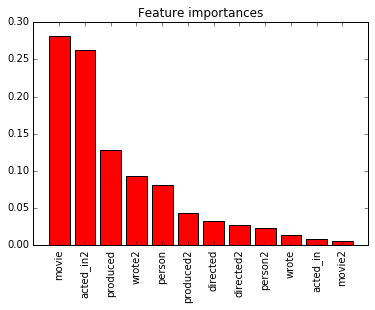

In [11]:
import numpy as np
import matplotlib.pyplot as plt

importances = domain_score.classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(domain_score.classifier.feature_importances_)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(domain_score.classifier.feature_importances_)), importances[indices],
       color="r", align="center")
a = list(domain_score.vectorizer.vocabulary_.values())
a.extend([i + len(list(domain_score.vectorizer.vocabulary_.values())) for i in list(domain_score.vectorizer.vocabulary_.values())])

features = list(domain_score.vectorizer.vocabulary_.keys())
features.extend([i + '2' for i in list(domain_score.vectorizer.vocabulary_.keys())])
features_ordered = [features[a.index(i)] for i in indices]

plt.xticks(range(0,len(features_ordered)), 
           features_ordered,
          rotation=90)
plt.xlim([-1, len(domain_score.classifier.feature_importances_)])
plt.show()

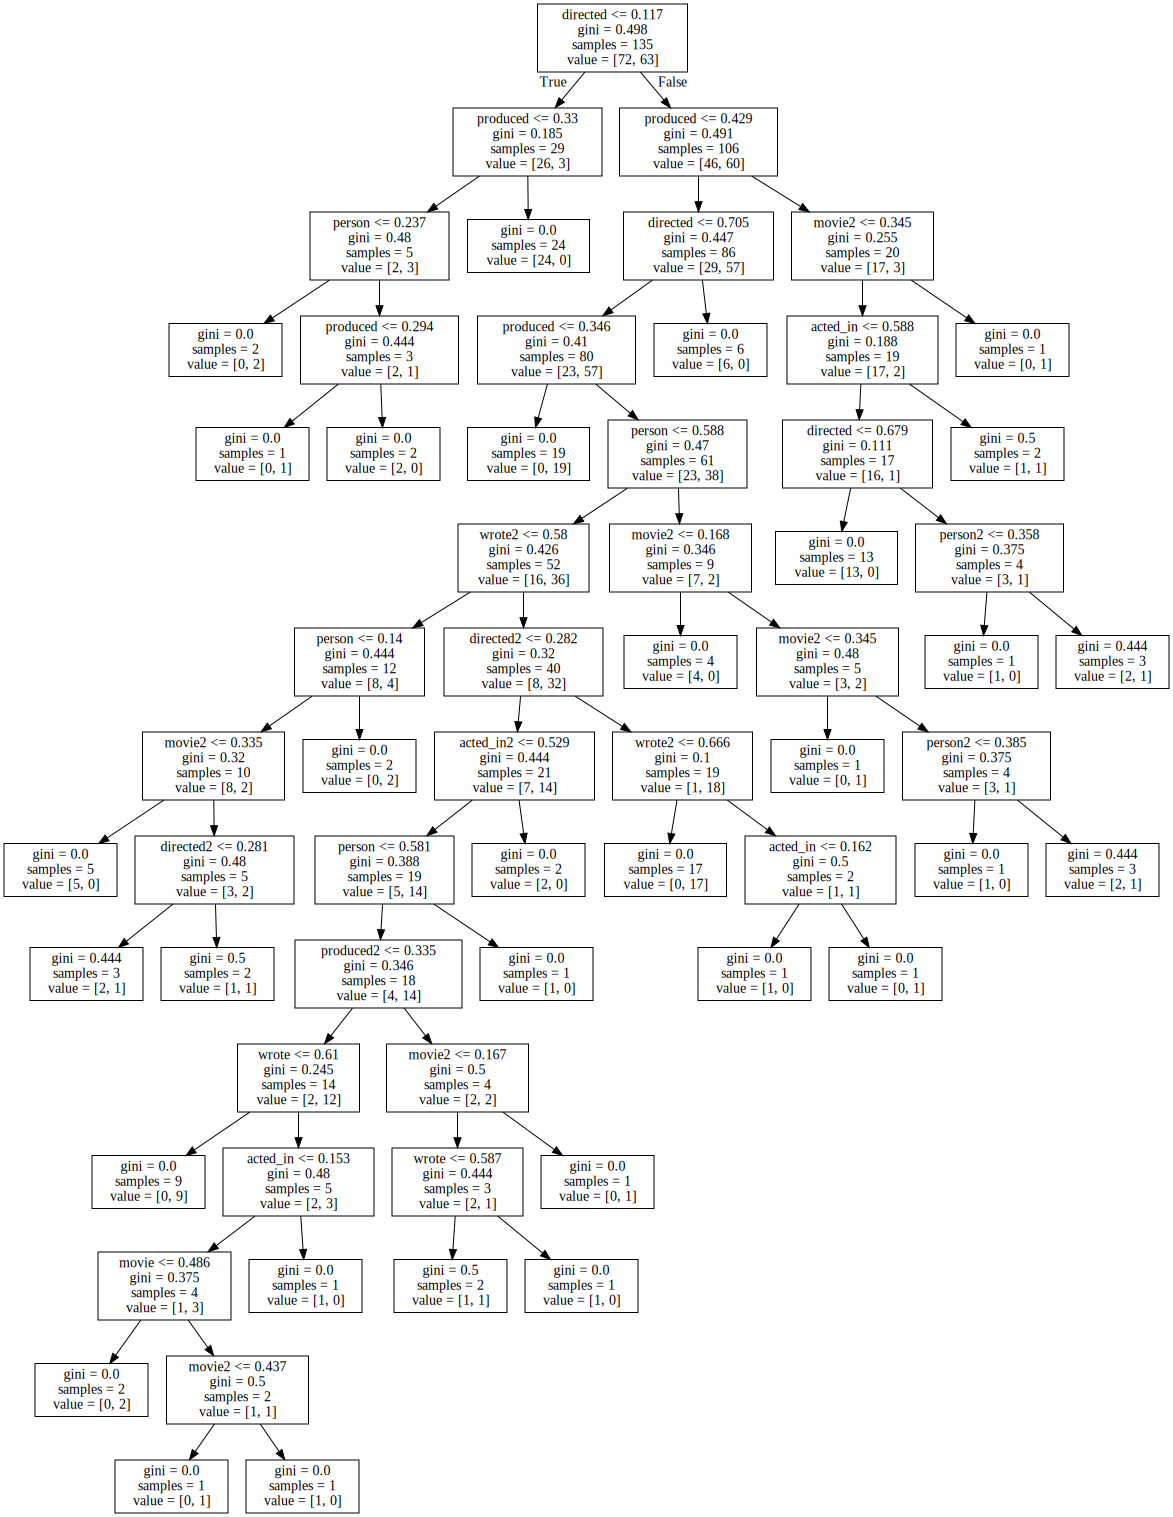

In [10]:
from sklearn.tree import export_graphviz
import graphviz
dot_data = export_graphviz(domain_score.classifier, out_file=None, feature_names=features_ordered)
graph = graphviz.Source(dot_data)  
graph 

**Feature names aren't correct**, somewhere they get messed up!
